# Few-Shot Graph Neural Networks for Cell-Type Classification in Spatial Transcriptomics
This notebook provides a comprehensive framework for classifying cell types in spatial transcriptomics data using few-shot learning. We will compare the performance of several models:
1.  **Baseline Model:** A standard Logistic Regression that ignores spatial information.
2.  **GNN-only Models:** GraphSAGE and GAT, which leverage the spatial graph of the tissue.
3.  **Hybrid Model:** A Transformer-based feature extractor combined with a GNN to learn richer node representations.

The goal is to demonstrate the data efficiency of GNN-based approaches in low-label scenarios (1, 5, and 10 shots).


# 1. SETUP AND ENVIRONMENT


## 1.1. Install Libraries

In [ ]:
# Note: Comment the following lines if the packages are already installed.
!pip install -q scanpy squidpy anndata
!pip install -q torch torchvision torchaudio
!pip install -q torch_geometric torch-scatter torch-sparse torch-cluster torch-spline-conv
!pip install -q python-igraph leidenalg
!pip install -q scikit-learn scikit-misc
print("Libraries installed.")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 18.3 MB/s eta 0:00:00
   ━━━━

## 1.2. Import Necessary Packages


In [ ]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import SAGEConv, GATv2Conv

import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


## 1.3. Set Seeds and Parameters for Reproducibility


In [ ]:
sc.set_figure_params(figsize=(8, 8), facecolor="white")
sc.settings.seed = 42
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 2. DATA LOADING AND PREPROCESSING

## 2.1. Load Data

In [ ]:
# ---
# **Action Required:**
# Place your data files in a directory and update `DATA_DIR` to point to it.
# The expected files are, for example:
# - `V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5`
# - `tissue_positions_list.csv`
# ---
DATA_DIR = "/content/drive/MyDrive/ERP/Breast_Cancer" # IMPORTANT: Update this path to your data directory

try:
    h5_path = f"{DATA_DIR}/V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5"
    positions_path = f"{DATA_DIR}/tissue_positions_list.csv"
    adata = sc.read_10x_h5(filename=h5_path)
    positions_df = pd.read_csv(positions_path, header=None, index_col=0)
except FileNotFoundError:
    print("="*80)
    print("ERROR: Data files not found.")
    print(f"Please make sure your .h5 and .csv files are in the directory: '{DATA_DIR}'")
    print("Update the `DATA_DIR` variable in the script if they are elsewhere.")
    print("="*80)
    # Create dummy adata to avoid crashing the rest of the script for demonstration
    adata = sc.AnnData(np.random.rand(100, 100))
    adata.obs_names = [f'cell_{i}' for i in range(100)]
    adata.var_names = [f'gene_{i}' for i in range(100)]
    positions_df = pd.DataFrame(np.random.randint(0,100, (100,5)), index=adata.obs_names)


adata.var_names_make_unique()

# Load and align spatial coordinates
positions_df.columns = [
    'in_tissue', 'array_row', 'array_col',
    'pxl_col_in_fullres', 'pxl_row_in_fullres'
]
common_barcodes = adata.obs_names.intersection(positions_df.index)
adata = adata[common_barcodes, :].copy()
positions_df = positions_df.loc[common_barcodes, :]
adata.obsm['spatial'] = positions_df[['pxl_col_in_fullres', 'pxl_row_in_fullres']].to_numpy()
adata.obs = adata.obs.join(positions_df)

print("--- Assembled AnnData Object ---")
print(adata)

--- Assembled AnnData Object ---
AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'


## 2.2. Preprocessing Pipeline


In [ ]:
print("\n--- Starting Preprocessing ---")
print(f"Initial state: {adata.n_obs} spots, {adata.n_vars} genes")

# 1. Quality Control and Filtering
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
sc.pp.filter_cells(adata, min_genes=200)
adata = adata[adata.obs['pct_counts_mt'] < 10, :]
adata = adata[adata.obs['total_counts'] < 60000, :]
sc.pp.filter_genes(adata, min_cells=10)
print(f"After filtering: {adata.n_obs} spots, {adata.n_vars} genes")

# 2. Normalization and Transformation
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

# 3. Highly Variable Gene (HVG) Selection
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='seurat_v3')
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
print(f"After HVG selection: {adata.n_obs} spots, {adata.n_vars} genes")

# 4. Scaling
sc.pp.scale(adata, max_value=10)

# 5. Dimensionality Reduction, Clustering, and Graph Construction
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, key_added="clusters", resolution=0.6) # Adjusted resolution for potentially better clusters
sq.gr.spatial_neighbors(adata, coord_type="grid", n_rings=1)

print("\n--- Preprocessing Complete ---")
print(adata)
print(f"\nIdentified clusters: {adata.obs['clusters'].nunique()}")


--- Starting Preprocessing ---
Initial state: 3798 spots, 36601 genes
After filtering: 3715 spots, 19618 genes
After HVG selection: 3715 spots, 4000 genes

--- Preprocessing Complete ---
AnnData object with n_obs × n_vars = 3715 × 4000
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters', 'spatial_neighbors'
    obsm: 'spatial',

# 3. MODEL DEFINITIONS

In [ ]:
# 3.1. GNN-only: GraphSAGE
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

# 3.2. GNN-only: GAT (Graph Attention Network)
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout_rate=0.6):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        self.conv2 = GATv2Conv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 3.3. Hybrid Model: Transformer Encoder + GNN
class TransformerNodeEncoder(nn.Module):
    def __init__(self, input_dim, model_dim=128, nhead=4, num_layers=1, dropout=0.1):
        super().__init__()
        self.model_dim = model_dim
        self.input_projection = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, model_dim))

    def forward(self, x):
        x_proj = self.input_projection(x).unsqueeze(1)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x_cat = torch.cat((cls_tokens, x_proj), dim=1)
        transformer_output = self.transformer_encoder(x_cat)
        return transformer_output[:, 0, :]

class HybridTransformerGNN(nn.Module):
    def __init__(self, input_dim, model_dim, gnn_hidden_dim, n_classes, dropout=0.5):
        super().__init__()
        self.node_encoder = TransformerNodeEncoder(input_dim, model_dim)
        self.gnn_conv1 = SAGEConv(model_dim, gnn_hidden_dim)
        self.gnn_conv2 = SAGEConv(gnn_hidden_dim, n_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.node_encoder(x))
        x = F.relu(self.gnn_conv1(x, edge_index))
        x = self.dropout(x)
        x = self.gnn_conv2(x, edge_index)
        return x

print("All model architectures defined.")

All model architectures defined.


# 4. EXPERIMENTAL FRAMEWORK


## 4.1. Prepare Data for PyTorch Geometric


In [ ]:
le = LabelEncoder()
adata.obs['clusters'] = adata.obs['clusters'].astype('category')
adata.obs['leiden_encoded'] = le.fit_transform(adata.obs['clusters'].cat.codes)
n_classes = len(le.classes_)

# Use scaled HVG matrix for GNNs, raw HVG for Transformer
node_features_scaled = torch.tensor(adata.X, dtype=torch.float)
edge_index, _ = from_scipy_sparse_matrix(adata.obsp['spatial_connectivities'])
labels = torch.tensor(adata.obs['leiden_encoded'].values, dtype=torch.long)

# Create a base data object
pyg_data = Data(x=node_features_scaled, edge_index=edge_index, y=labels)
print("\nBase PyG Data object created.")
print(pyg_data)


Base PyG Data object created.
Data(x=[3715, 4000], edge_index=[2, 21258], y=[3715])


## 4.2. Training and Evaluation Functions


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pyg_data = pyg_data.to(device)

def train_model(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate_model(model, data):
    model.eval()
    out = model(data)
    if isinstance(criterion, nn.NLLLoss): # For GAT with log_softmax
        pred = out.argmax(dim=1)
    else:
        pred = out.argmax(dim=1)

    accs = []
    for mask_name in ['train_mask', 'val_mask', 'test_mask']:
        mask = data[mask_name]
        acc = (pred[mask] == data.y[mask]).sum() / mask.sum()
        accs.append(acc.item())
    return accs # [train_acc, val_acc, test_acc]

## 4.3. Run Few-Shot Experiments

In [ ]:
shots_to_test = [1, 5, 10]
results = {}

for n_shots in shots_to_test:
    print(f"\n{'='*20} RUNNING EXPERIMENT FOR {n_shots}-SHOT {'='*20}")

    # 1. Create Few-Shot Split
    train_indices, val_indices = [], []
    for c in range(n_classes):
        class_indices = np.where(adata.obs['leiden_encoded'] == c)[0]
        np.random.shuffle(class_indices)
        train_indices.extend(class_indices[:n_shots])
        val_end = n_shots + min(10, len(class_indices[n_shots:]) // 2)
        val_indices.extend(class_indices[n_shots:val_end])

    pyg_data.train_mask = torch.zeros(adata.n_obs, dtype=torch.bool)
    pyg_data.val_mask = torch.zeros(adata.n_obs, dtype=torch.bool)
    pyg_data.test_mask = torch.zeros(adata.n_obs, dtype=torch.bool)

    pyg_data.train_mask[train_indices] = True
    pyg_data.val_mask[val_indices] = True
    pyg_data.test_mask = ~(pyg_data.train_mask | pyg_data.val_mask)
    pyg_data = pyg_data.to(device)

    print(f"Data split: Train-{pyg_data.train_mask.sum()}, Val-{pyg_data.val_mask.sum()}, Test-{pyg_data.test_mask.sum()}")

    # Store results for this shot count
    results[n_shots] = {}

    # 2. Baseline: Logistic Regression
    print("\n--- Training Baseline (Logistic Regression) ---")
    X_train = adata.X[pyg_data.train_mask.cpu().numpy()]
    y_train = adata.obs['leiden_encoded'][pyg_data.train_mask.cpu().numpy()]
    X_test = adata.X[pyg_data.test_mask.cpu().numpy()]
    y_test = adata.obs['leiden_encoded'][pyg_data.test_mask.cpu().numpy()]

    baseline_model = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)
    y_pred = baseline_model.predict(X_test)
    baseline_acc = accuracy_score(y_test, y_pred)
    results[n_shots]['Baseline'] = baseline_acc
    print(f"Baseline Test Accuracy: {baseline_acc:.4f}")


    # 3. GNN Models Training
    models_to_run = {
        "GraphSAGE": GraphSAGE(pyg_data.num_node_features, 128, n_classes),
        "GAT": GAT(pyg_data.num_node_features, 32, n_classes),
        "Hybrid-GNN": HybridTransformerGNN(pyg_data.num_node_features, 128, 64, n_classes)
    }

    for model_name, model in models_to_run.items():
        print(f"\n--- Training {model_name} ---")
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

        if model_name == "GAT":
            criterion = torch.nn.NLLLoss() # GAT model uses log_softmax
        else:
            criterion = torch.nn.CrossEntropyLoss()

        best_val_acc = 0
        final_test_acc = 0
        for epoch in range(1, 201):
            loss = train_model(model, pyg_data, optimizer, criterion)
            _, val_acc, test_acc = evaluate_model(model, pyg_data)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                final_test_acc = test_acc

            if epoch % 50 == 0:
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

        results[n_shots][model_name] = final_test_acc
        print(f"{model_name} Test Accuracy: {final_test_acc:.4f}")


==================== RUNNING EXPERIMENT FOR 1-SHOT ====================
Data split: Train-11, Val-110, Test-3594

--- Training Baseline (Logistic Regression) ---
Baseline Test Accuracy: 0.3027

--- Training GraphSAGE ---
Epoch: 050, Loss: 0.0000, Val Acc: 0.5273
Epoch: 100, Loss: 0.2606, Val Acc: 0.3636
Epoch: 150, Loss: 0.0004, Val Acc: 0.3818
Epoch: 200, Loss: 0.0000, Val Acc: 0.4455
GraphSAGE Test Accuracy: 0.6483

--- Training GAT ---
Epoch: 050, Loss: 3.2448, Val Acc: 0.3727
Epoch: 100, Loss: 5.2290, Val Acc: 0.3545
Epoch: 150, Loss: 12.5488, Val Acc: 0.4273
Epoch: 200, Loss: 5.8817, Val Acc: 0.4000
GAT Test Accuracy: 0.3957

--- Training Hybrid-GNN ---
Epoch: 050, Loss: 0.0014, Val Acc: 0.5455
Epoch: 100, Loss: 0.0013, Val Acc: 0.4545
Epoch: 150, Loss: 0.0186, Val Acc: 0.4091
Epoch: 200, Loss: 0.0029, Val Acc: 0.4455
Hybrid-GNN Test Accuracy: 0.5442

==================== RUNNING EXPERIMENT FOR 5-SHOT ====================
Data split: Train-55, Val-110, Test-3550

--- Training Bas

# 5. RESULTS AND ANALYSIS

## 5.1. Plot Final Comparison




                           FINAL RESULTS SUMMARY
       Baseline  GraphSAGE       GAT  Hybrid-GNN
Shots                                           
1      0.302727   0.648303  0.395659    0.544240
5      0.827606   0.841408  0.625352    0.701408
10     0.864950   0.790272  0.777969    0.803147


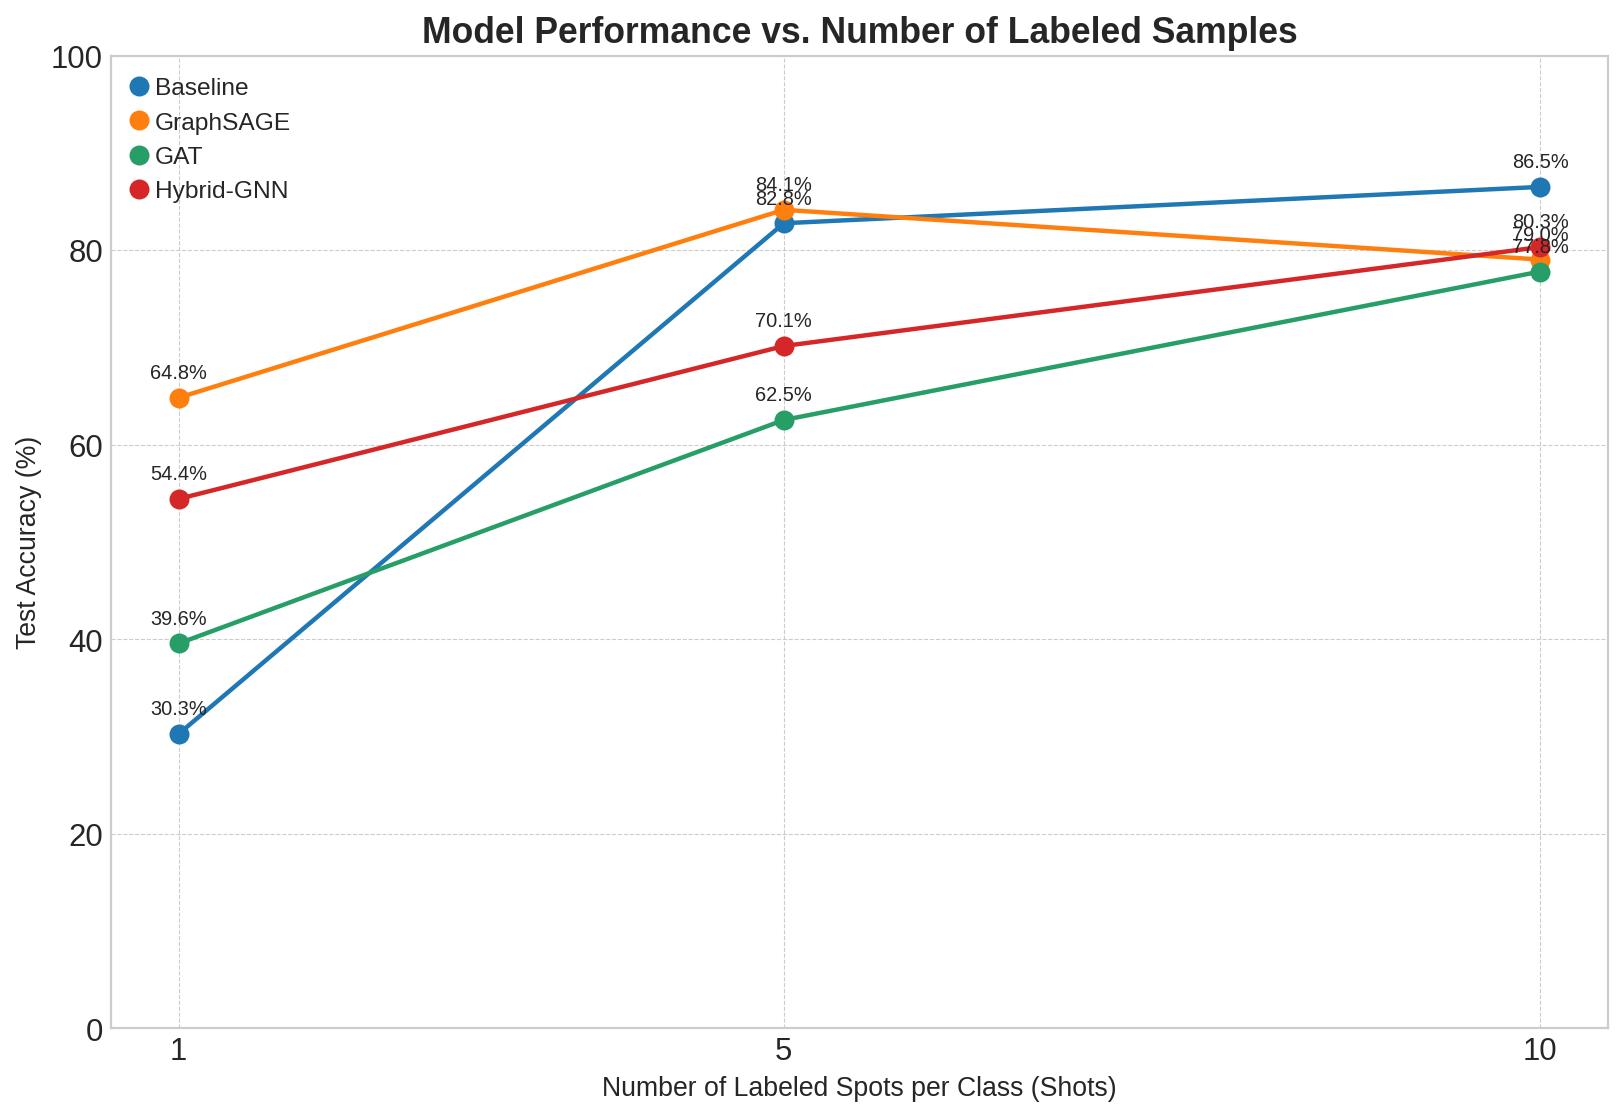

In [ ]:
print("\n\n" + "="*80)
print("                           FINAL RESULTS SUMMARY")
print("="*80)

# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame(results).T # Transpose to have shots as index
results_df.index.name = 'Shots'

print(results_df)

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

for model_name in results_df.columns:
    ax.plot(results_df.index, results_df[model_name] * 100, 'o-', label=model_name, linewidth=2, markersize=8)

# Add titles and labels
ax.set_title('Model Performance vs. Number of Labeled Samples', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Labeled Spots per Class (Shots)', fontsize=12)
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.legend(fontsize=11)
ax.set_xticks(shots_to_test)
ax.set_ylim(0, 100)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add text annotations
for model_name in results_df.columns:
    for shot, acc in results_df[model_name].items():
        ax.text(shot, acc * 100 + 2, f'{acc*100:.1f}%', ha='center', fontsize=9)

plt.show()

## 5.3. Biological Interpretation: Visualize Final Predictions (10 shot scenario)



--- Visualizing Predicted Clusters for Biological Interpretation ---
Original best model at 10 shots was Baseline (0.8649).
Visualizing predictions for the BEST GNN-BASED model at 10 shots: Hybrid-GNN (0.8031)
Briefly re-training the selected GNN model...
Re-training epoch 50...
Re-training epoch 100...
Re-training epoch 150...
Generating predictions...
Displaying comparison plot...


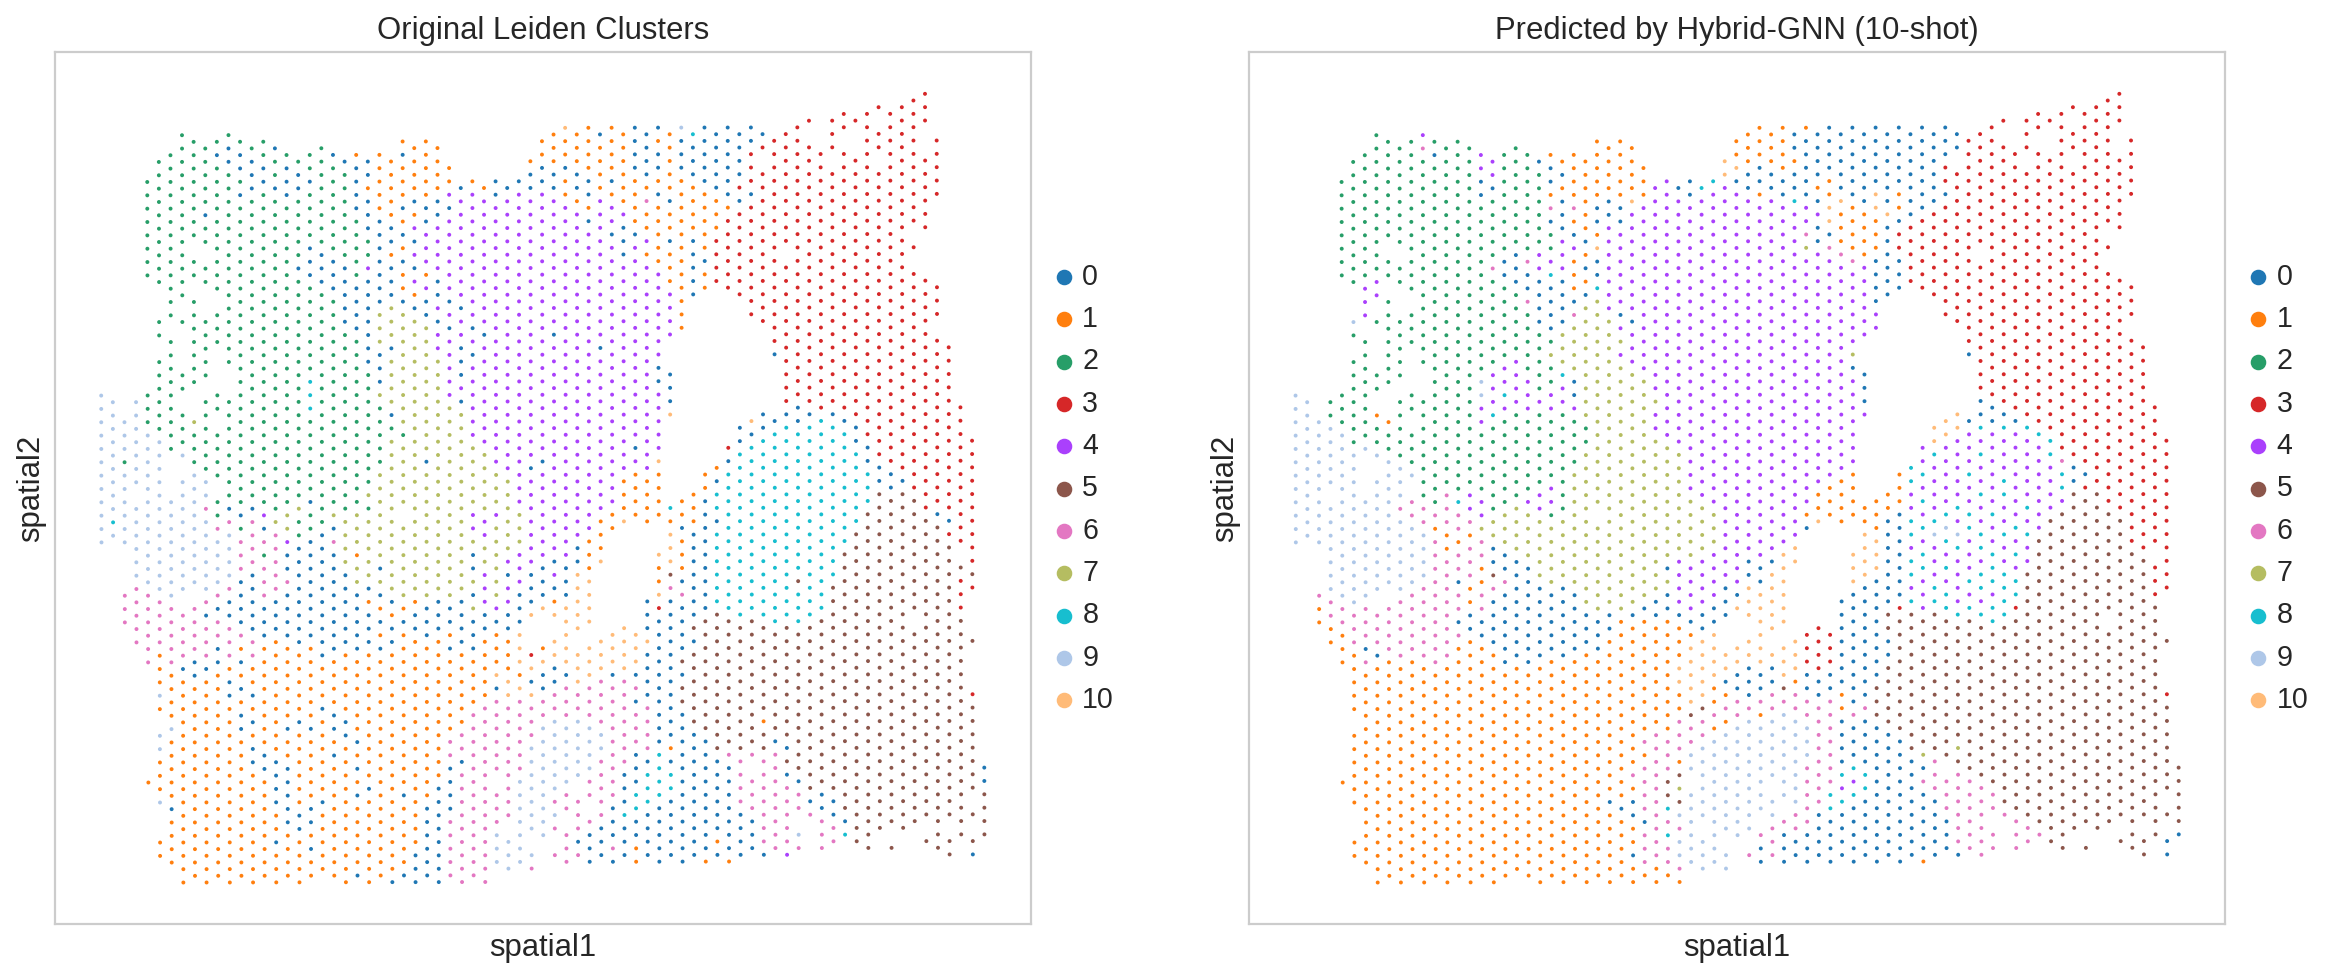

In [ ]:
print("\n--- Visualizing Predicted Clusters for Biological Interpretation ---")

# First, ensure the results DataFrame exists and is not empty.
if 'results_df' in locals() and not results_df.empty:

    # We create a new DataFrame without the 'Baseline' column for this selection.
    gnn_results_df = results_df.drop(columns=['Baseline'])
    best_gnn_model_name = gnn_results_df.loc[10].idxmax()

    print(f"Original best model at 10 shots was Baseline ({results_df.loc[10, 'Baseline']:.4f}).")
    print(f"Visualizing predictions for the BEST GNN-BASED model at 10 shots: {best_gnn_model_name} ({gnn_results_df.loc[10, best_gnn_model_name]:.4f})")
    # END OF CHANGE

    # Map model name to its class definition
    model_class_map = {
        "GraphSAGE": GraphSAGE,
        "GAT": GAT,
        "Hybrid-GNN": HybridTransformerGNN
    }

    # Instantiate the final model with correct parameters
    if best_gnn_model_name in model_class_map:
        if best_gnn_model_name == "GAT":
            final_model = GAT(pyg_data.num_node_features, 32, n_classes)
        elif best_gnn_model_name == "Hybrid-GNN":
            final_model = HybridTransformerGNN(pyg_data.num_node_features, 128, 64, n_classes)
        else: # Default to GraphSAGE parameters
            final_model = GraphSAGE(pyg_data.num_node_features, 128, n_classes)

        final_model = final_model.to(device)
        optimizer = torch.optim.Adam(final_model.parameters(), lr=0.005)
        criterion = torch.nn.NLLLoss() if best_gnn_model_name == "GAT" else torch.nn.CrossEntropyLoss()

        # Re-train the model to get it into a predictive state
        print("Briefly re-training the selected GNN model...")
        for epoch in range(1, 151): # Quick training run
            train_model(final_model, pyg_data, optimizer, criterion)
            if epoch % 50 == 0:
                print(f"Re-training epoch {epoch}...")

        # Get final predictions for the entire dataset
        print("Generating predictions...")
        final_model.eval()
        with torch.no_grad():
            all_predictions = final_model(pyg_data).argmax(dim=1).cpu().numpy()

        # Add predictions to the AnnData object for plotting
        adata.obs['predicted_clusters'] = le.inverse_transform(all_predictions)
        adata.obs['predicted_clusters'] = adata.obs['predicted_clusters'].astype('category')

        # Plot side-by-side comparison using scanpy
        print("Displaying comparison plot...")
        sc.pl.spatial(adata, color=['clusters', 'predicted_clusters'], spot_size=80,
                      title=[f'Original Leiden Clusters', f'Predicted by {best_gnn_model_name} (10-shot)'],
                      show=True)
    else:
        print("Could not find a valid GNN model to visualize.")
else:
    print("Could not find the 'results_df' DataFrame. Please run the experimental framework first.")

# 5.4. Biological Interpretation: Visualize Final Predictions (1-Shot Scenario)


--- Visualizing Predicted Clusters for 1-Shot Scenario ---
Visualizing predictions for the BEST GNN-BASED model at 1 shot: GraphSAGE (0.6483)
Briefly re-training the selected GNN model on 1-shot data...
Re-training epoch 50...
Re-training epoch 100...
Re-training epoch 150...
Generating predictions...
Displaying comparison plot...


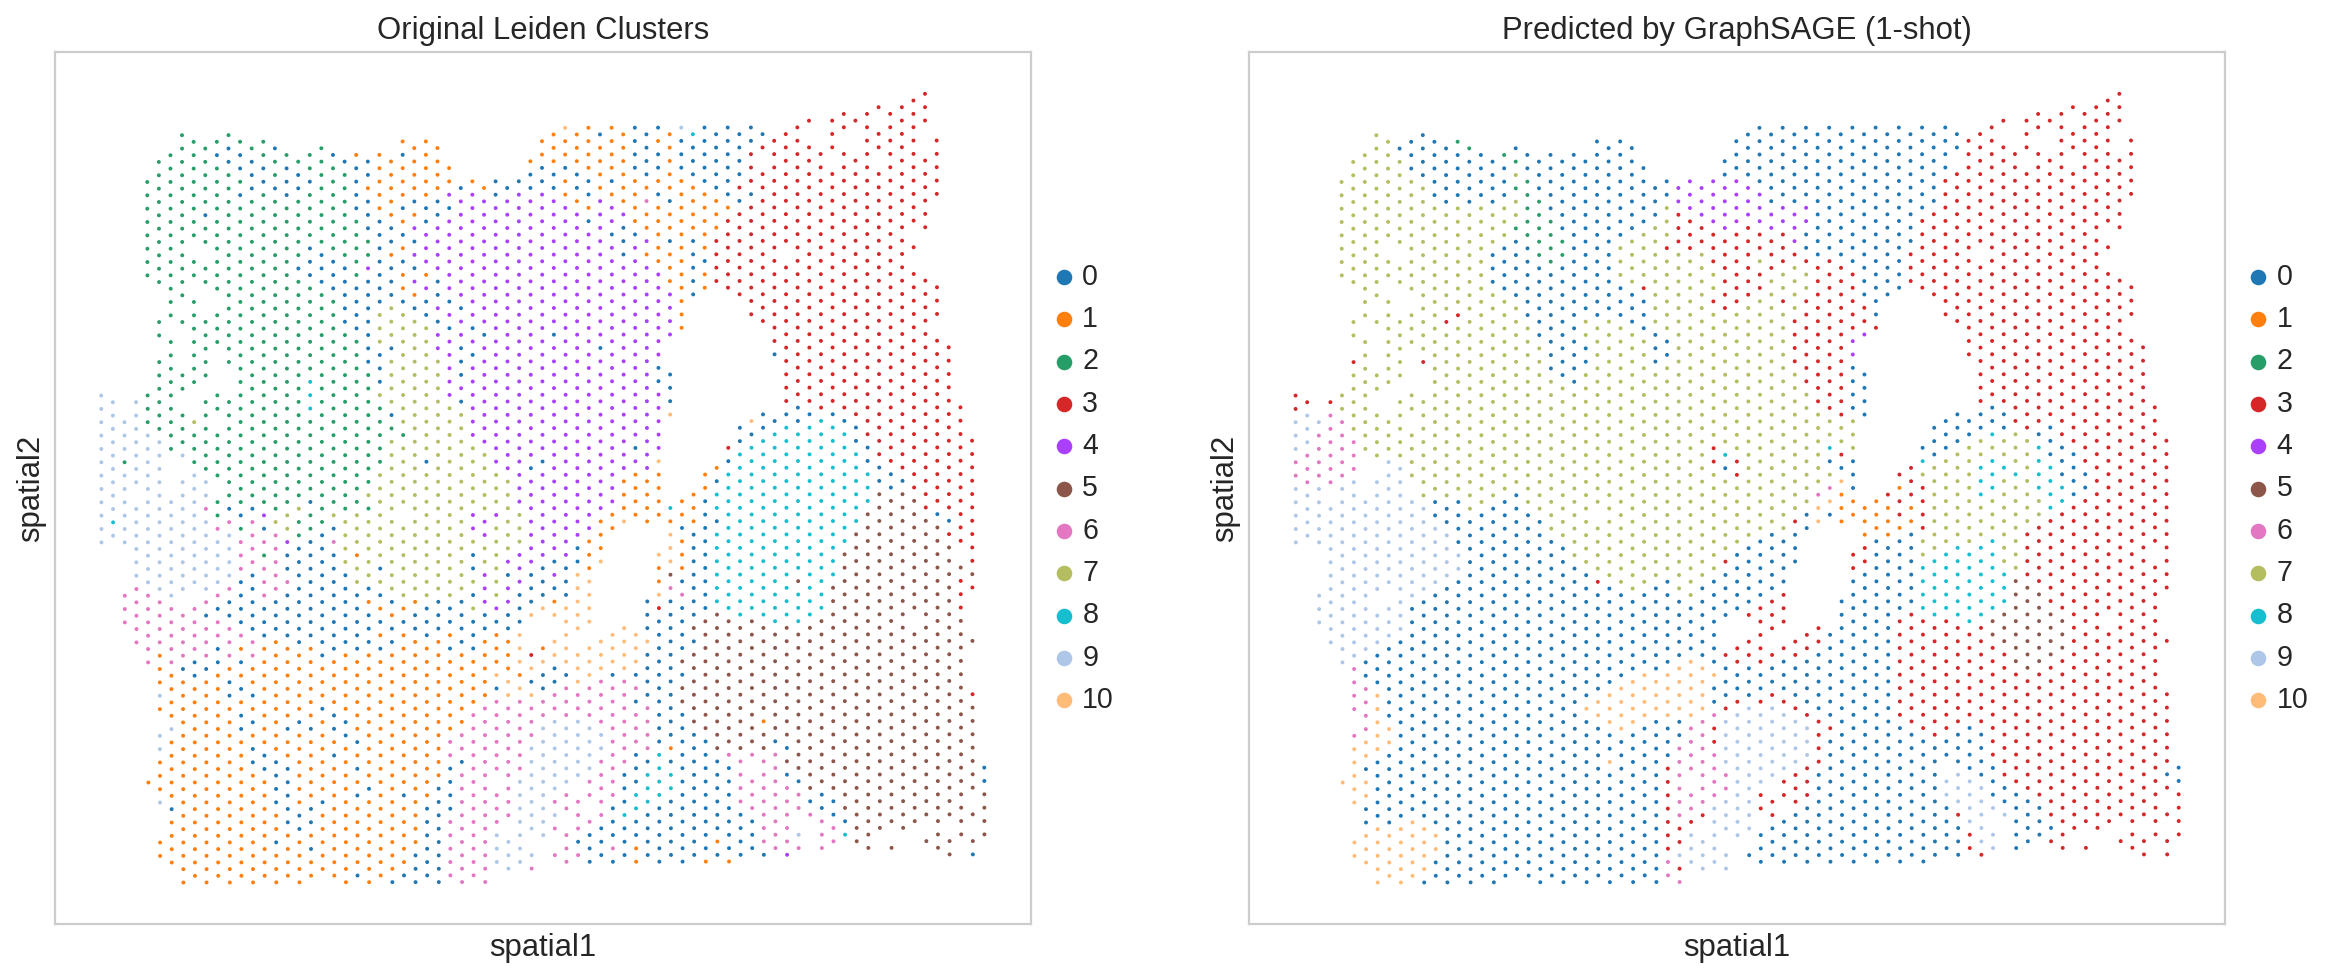

In [ ]:
print("\n--- Visualizing Predicted Clusters for 1-Shot Scenario ---")

# First, ensure the results DataFrame exists and is not empty.
if 'results_df' in locals() and not results_df.empty:

    # Find the best performing GNN model from the 1-shot results
    # We create a new DataFrame without the 'Baseline' column for this selection.
    gnn_results_df = results_df.drop(columns=['Baseline'])
    best_gnn_model_name_1shot = gnn_results_df.loc[1].idxmax()

    print(f"Visualizing predictions for the BEST GNN-BASED model at 1 shot: {best_gnn_model_name_1shot} ({gnn_results_df.loc[1, best_gnn_model_name_1shot]:.4f})")

    # Re-train the best model on the 1-shot split to get its final state for prediction

    # 1. Define the 1-shot data split again for reproducibility
    pyg_data.train_mask = torch.zeros(adata.n_obs, dtype=torch.bool)
    train_indices_1shot, val_indices_1shot = [], []
    for c in range(n_classes):
        class_indices = np.where(adata.obs['leiden_encoded'] == c)[0]
        np.random.shuffle(class_indices) # Shuffling with the same seed ensures the same split
        train_indices_1shot.extend(class_indices[:1])
        val_end = 1 + min(10, len(class_indices[1:]) // 2)
        val_indices_1shot.extend(class_indices[1:val_end])
    pyg_data.train_mask[train_indices_1shot] = True
    pyg_data = pyg_data.to(device)

    # 2. Map model name to its class definition
    model_class_map = {
        "GraphSAGE": GraphSAGE,
        "GAT": GAT,
        "Hybrid-GNN": HybridTransformerGNN
    }

    # 3. Instantiate the final model
    if best_gnn_model_name_1shot in model_class_map:
        if best_gnn_model_name_1shot == "GAT":
            final_model_1shot = GAT(pyg_data.num_node_features, 32, n_classes)
        elif best_gnn_model_name_1shot == "Hybrid-GNN":
            final_model_1shot = HybridTransformerGNN(pyg_data.num_node_features, 128, 64, n_classes)
        else: # Default to GraphSAGE parameters
            final_model_1shot = GraphSAGE(pyg_data.num_node_features, 128, n_classes)

        final_model_1shot = final_model_1shot.to(device)
        optimizer = torch.optim.Adam(final_model_1shot.parameters(), lr=0.005)
        criterion = torch.nn.NLLLoss() if best_gnn_model_name_1shot == "GAT" else torch.nn.CrossEntropyLoss()

        # 4. Briefly train the model
        print("Briefly re-training the selected GNN model on 1-shot data...")
        for epoch in range(1, 151): # A quick training run
            train_model(final_model_1shot, pyg_data, optimizer, criterion)
            if epoch % 50 == 0:
                print(f"Re-training epoch {epoch}...")

        # 5. Get final predictions for the entire dataset
        print("Generating predictions...")
        final_model_1shot.eval()
        with torch.no_grad():
            all_predictions_1shot = final_model_1shot(pyg_data).argmax(dim=1).cpu().numpy()

        # 6. Add predictions to a NEW column in the AnnData object
        adata.obs['predicted_clusters_1shot'] = le.inverse_transform(all_predictions_1shot)
        adata.obs['predicted_clusters_1shot'] = adata.obs['predicted_clusters_1shot'].astype('category')

        # 7. Plot side-by-side comparison
        print("Displaying comparison plot...")
        sc.pl.spatial(adata, color=['clusters', 'predicted_clusters_1shot'], spot_size=80,
                      title=[f'Original Leiden Clusters', f'Predicted by {best_gnn_model_name_1shot} (1-shot)'],
                      show=True)
    else:
        print(f"Could not find a valid GNN model named '{best_gnn_model_name_1shot}' to visualize.")
else:
    print("Could not find the 'results_df' DataFrame. Please run the experimental framework first.")